Objetivo deste notebook é analisar a série temporal 'Ocupação'

Dataset: Pessoas de 14 anos ou mais de idade, ocupadas na semana de referência (milhares) 2022 - 2023
Fonte: https://sidra.ibge.gov.br/home/pnadcm/brasil

## Imports

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tseries.offsets import DateOffset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from statsmodels.tsa.arima.model import ARIMA

## Tratamento dos dados

In [25]:
# Lendo os dados já tratados.

df = pd.read_csv('../data/nascimento/nascimentos_2020-2022.csv')
df = df.T
df = df.rename(columns={0:"pessoas_trabalhando"})
df.index = pd.to_datetime(df.index)
df.index = df.index.to_period("M")
df.pessoas_trabalhando = pd.to_numeric(df.pessoas_trabalhando)
index = df.index.to_timestamp()

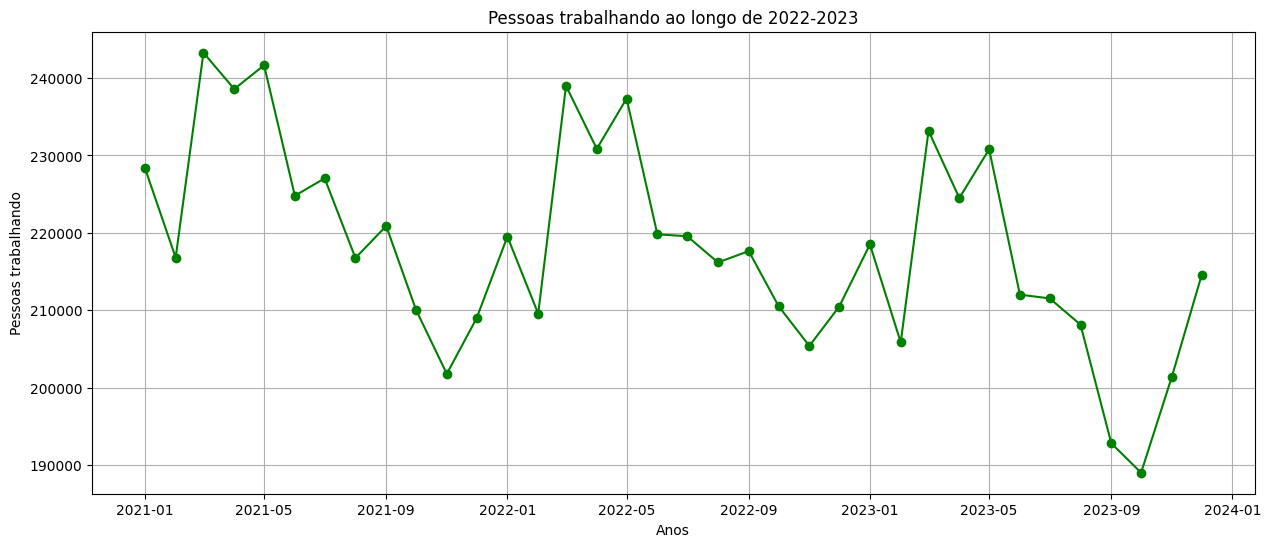

In [26]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the data
ax.plot(index, df['pessoas_trabalhando'], marker='o', linestyle='-', color='green')

# Set title and labels
ax.set_title('Pessoas trabalhando ao longo de 2022-2023')
ax.set_xlabel('Anos')
ax.set_ylabel('Pessoas trabalhando')

# Enable grid
ax.grid(True)

# Show plot
plt.show()

## Iniciação da decomposição 

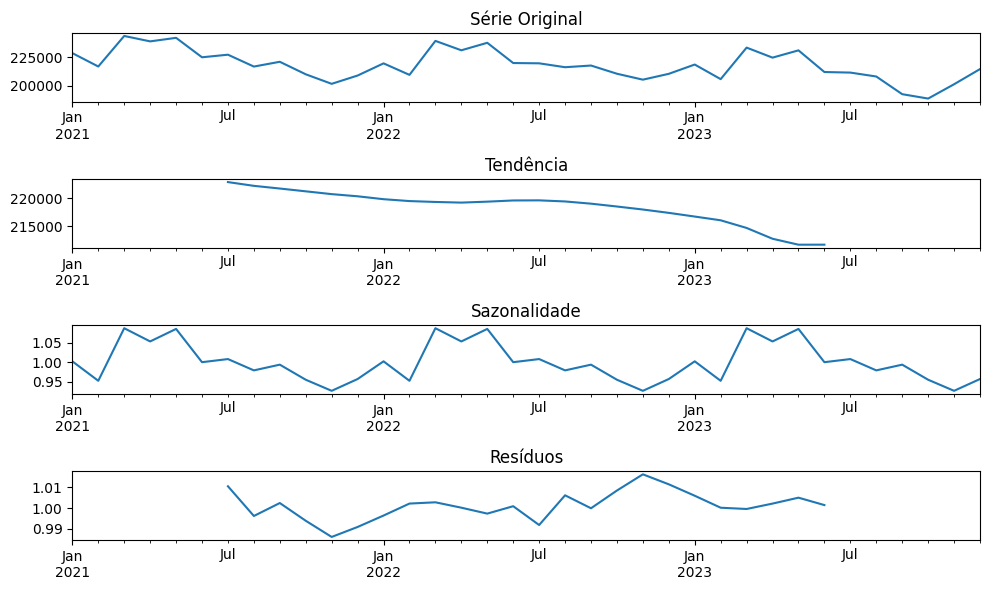

In [27]:
decomposition = seasonal_decompose(df.pessoas_trabalhando, model='multiplicative', period=12)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 6))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Série Original')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Tendência')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Sazonalidade')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Resíduos')
plt.tight_layout()
plt.show()

###  Série Original: 
Este é o gráfico da série temporal de dados original, mostra as flutuações ao longo do tempo. Podemos observar que existem variações periódicas e alguns picos e vales ao longo da série.

### Tendência
O gráfico de tendência mostra como a série temporal evolui ao longo do tempo, excluindo a sazonalidade e o ruído. Há uma tendência geral de aumento, indicando que há um crescimento ou uma tendência ascendente na série ao longo do período observado. Exatamente como havíamos pontuado antes!

### Sazonalidade
Este componente revela padrões que se repetem em intervalos regulares. O gráfico da sazonalidade não mostra um padrão claro e repetitivo, sugerindo que a sazonalidade pode não ser um fator significativo na série temporal ou que o período de sazonalidade pode não estar bem capturado.

### Resíduos
Este gráfico mostra o que resta da série temporal após a remoção da tendência e da sazonalidade. Os resíduos representam a flutuação aleatória que não pode ser explicada pelos modelos de tendência ou sazonalidade. O ideal é que os resíduos pareçam ser ruído branco, ou seja, sem padrões discerníveis, o que indicaria que a tendência e a sazonalidade foram bem capturadas nos outros componentes.

## Teste ADF para ver se esta série temporal é estacionária

In [28]:
# Diferenciação

df['diff_pessoas_trabalhando'] = df['pessoas_trabalhando'].diff().fillna(0)

# Realizando o teste ADF na série temporal 'diff_net_revenue'
adf_test_result_diff = adfuller(df['diff_pessoas_trabalhando'])

# Criando um DataFrame para exibir os resultados do teste de forma mais clara
# Incluindo os valores críticos
adf_test_result_diff = pd.DataFrame({
    'Item': [
        'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used',
        'Critical Value (1%)', 'Critical Value (5%)', 'Critical Value (10%)'
    ],
    'Value': [
        adf_test_result_diff[0],  # Test statistic
        adf_test_result_diff[1],  # p-value
        adf_test_result_diff[2],  # #Lags Used
        adf_test_result_diff[3],  # Number of Observations Used
        adf_test_result_diff[4]['1%'],  # Critical Value for 1%
        adf_test_result_diff[4]['5%'],  # Critical Value for 5%
        adf_test_result_diff[4]['10%']  # Critical Value for 10%
    ]
})

adf_test_result_diff

,Item,Value
0,Test Statistic,-5.547240
1,p-value,0.000002
2,#Lags Used,10.000000
3,Number of Observations Used,25.000000
4,Critical Value (1%),-3.723863
5,Critical Value (5%),-2.986489
6,Critical Value (10%),-2.632800


p-value > 0.05 ; logo, não é estacionária

Além disso:  CV(1%) > Test Statistic > CV(5%). Logo, a hipótese nula pode ser rejeitada com um nível de confiança de <=90% 

### Como a série possui sazonalidade, usar SARIMAX como modelo de predição.

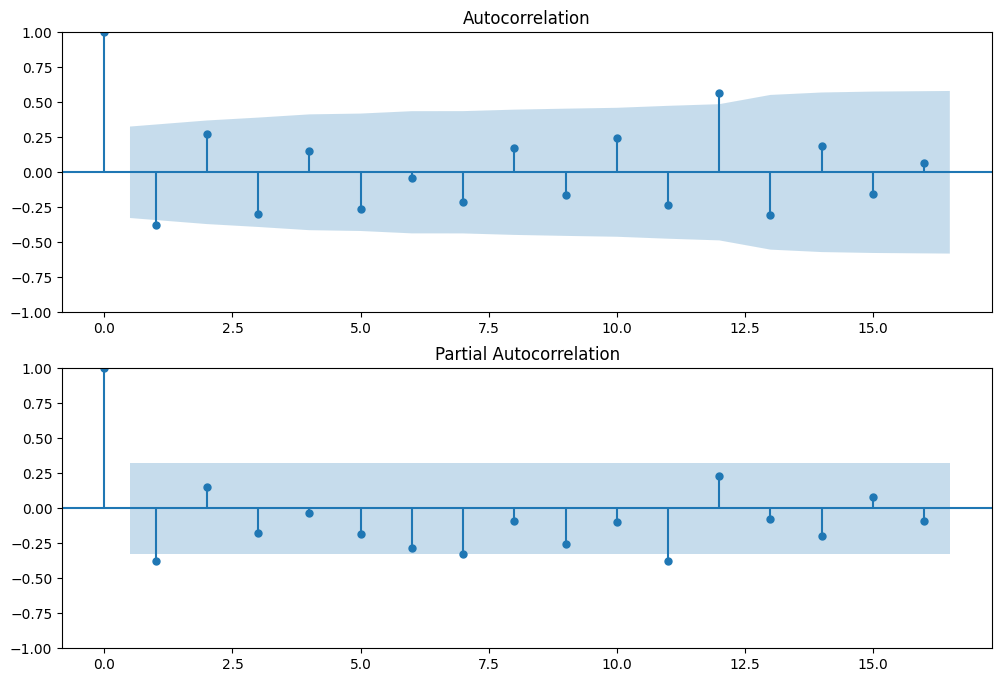

In [29]:
# Plotando ACF e PACF para descobrir os melhores hiperparâmetros do SARIMAX
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Autocorrelação
plot_acf(df['diff_pessoas_trabalhando'], ax=ax1)

# Autocorrelação Parcial
plot_pacf(df['diff_pessoas_trabalhando'], ax=ax2, method='ywm')

plt.show()

In [30]:
p = 1  # ordem do componente autoregressivo
d = 1  # ordem de diferenciação
q = 1  # ordem do componente de média móvel

# Modelo SARIMAX
model = SARIMAX(df['pessoas_trabalhando'], order=(p, d, q), seasonal_order=(1, 1, 0, 12))
model_fit = model.fit(disp=False)

## Fazendo a previsão com SARIMAX

In [31]:
# Previsões das datas futuras
future_dates = [index[-1] + DateOffset(weeks=x) for x in range(1, 53)]

# Previsões dos valores
forecast_object = model_fit.get_forecast(steps=52)

# Intervalo de confiança
confianca = forecast_object.conf_int()


# Criando dataset com os valores futuros colhidos
forecast_df = pd.DataFrame({
    'date': future_dates,
    'predicted_pessoas_trabalhando': forecast_object.predicted_mean,
    'lower_confidence': confianca.iloc[:, 0],
    'upper_confidence': confianca.iloc[:, 1]
})

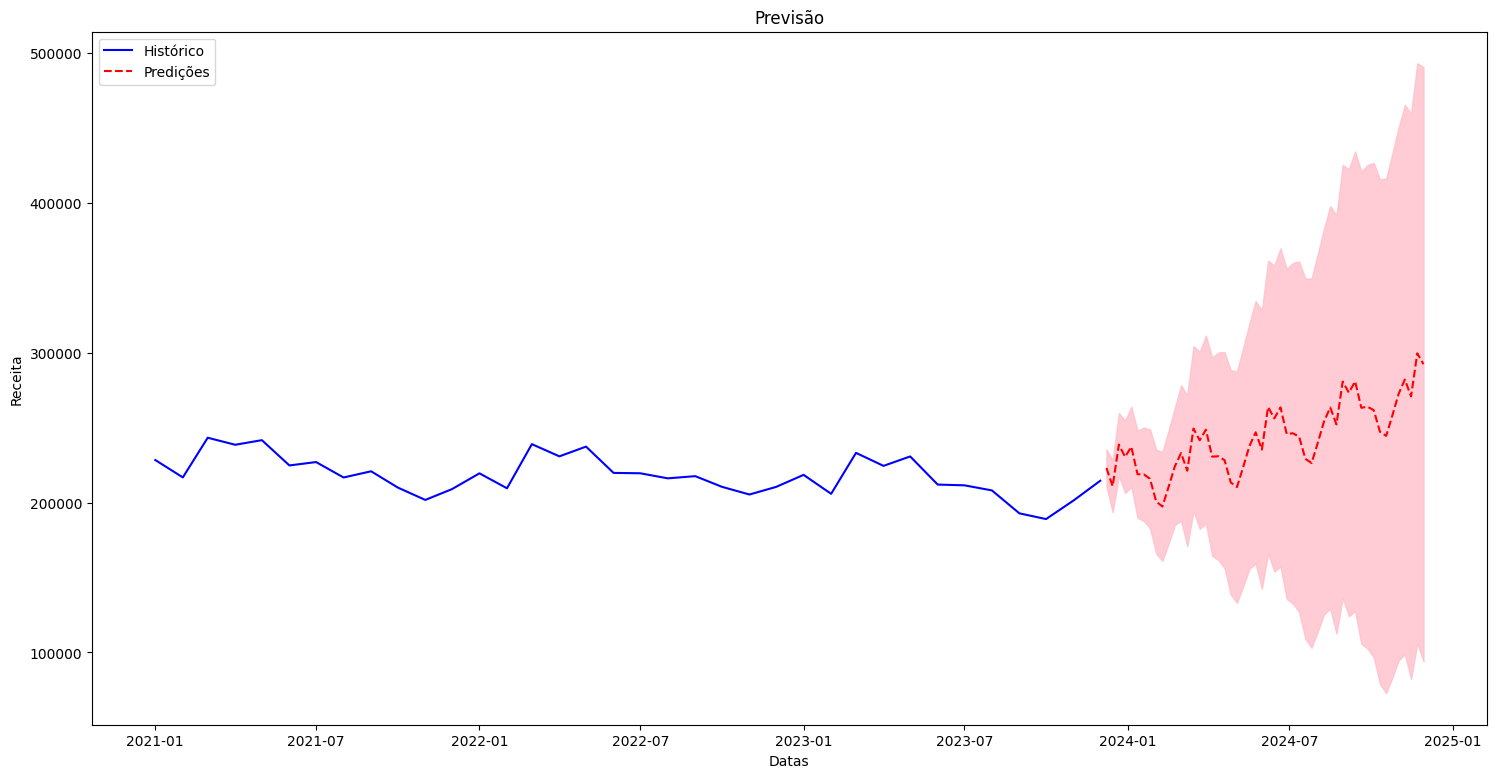

In [32]:
# Plotando os dados históricos e as previsões
plt.figure(figsize=(18, 9))
plt.plot(index, df['pessoas_trabalhando'], label='Histórico', color='blue')
plt.plot(forecast_df['date'], forecast_df['predicted_pessoas_trabalhando'], label='Predições', color='red', linestyle='--')
# Adicionando intervalo de confiança
plt.fill_between(forecast_df['date'],forecast_df['lower_confidence'],forecast_df['upper_confidence'], color='pink', alpha=0.8)
plt.title('Previsão')
plt.xlabel('Datas')
plt.ylabel('Receita')
plt.legend()
plt.show()

## Conclusão
Mesmo que essa série temporal tenha sazonalidade, a previsão com SARIMAX não teve resultados agradáveis.

In [39]:
#nascimentos_predict=forecast_df['2024-01':'2024-12'].to_csv('predict_nascimentos.csv')